# Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_



**🚨 WARNING**: This notebook is resource-intensive and requires substantial computational power. If you're running this in Colab, it will utilize an A100 GPU.

In this notebook, we demonstrate how to build a **Multimodal Retrieval-Augmented Generation (RAG)** system by combining the **ColPali** retriever for document retrieval with the **Qwen2-VL** Vision Language Model (VLM). Together, these models form a powerful RAG system capable of enhancing query responses with both text-based documents and visual data.

Instead of relying on a complex document processor pipeline that extracts data through OCR, we will leverage a Document Retrieval Model to efficiently retrieve the relevant documents based on a specific user query.

I also recommend checking out and starring the [smol-vision](https://github.com/merveenoyan/smol-vision) repository, which inspired this notebook—especially [this notebook](https://github.com/merveenoyan/smol-vision/blob/main/ColPali_%2B_Qwen2_VL.ipynb).




## 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀

We will install **Transformers** from source, as the **Qwen2-VL** Vision Language Model (VLM) we’re using is not yet included in the packaged version. Once the package is officially released, this installation method can be updated accordingly. Let’s get started!



In [ ]:
!pip install -U -q byaldi pdf2image qwen-vl-utils git+https://github.com/huggingface/transformers.git #flash-attn
# Tested with byaldi==0.0.4, pdf2image==1.17.0, qwen-vl-utils==0.0.8, transformers==4.45.0.dev0

We will also install **poppler-utils** to facilitate PDF manipulation. This utility provides essential tools for working with PDF files, ensuring we can efficiently handle any document-related tasks in our project.


In [2]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 2s (118 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123605 

In [3]:
# Login needed because ColPali uses: https://huggingface.co/google/paligemma-3b-mix-448 // https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#colpali-access

#from huggingface_hub import notebook_login

#notebook_login()

## 2. Load Dataset 📁

In this section, we will utilize IKEA assembly instructions as our dataset. These PDFs contain step-by-step guidance for assembling various furniture pieces. Imagine being able to ask our assistant for help while assembling your new IKEA furniture! 🛋

To download the assembly instructions, you can follow [these steps](https://www.ikea.com/us/en/customer-service/assembly-instructions-puba2cdc880).

For this notebook, I've selected a few examples, but in a real-world scenario, we could work with a large collection of PDFs to enhance our model’s capabilities.


In [4]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/MALM.pdf
Downloaded BILLY to data/BILLY.pdf
Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded ADILS to data/ADILS.pdf
Downloaded MICKE to data/MICKE.pdf
Downloaded files: ['ADILS.pdf', 'MALM.pdf', 'BILLY.pdf', 'MICKE.pdf', 'BOAXEL.pdf']


After downloading the assembly instructions, we will convert the PDFs into images. This step is crucial, as it allows the document retrieval model (ColPali) to process and manipulate the visual content effectively.


In [5]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("/content/data/")

Let’s visualize a sample assembly guide to get a sense of how these instructions are presented! This will help us understand the format and layout of the content we’ll be working with. 👀


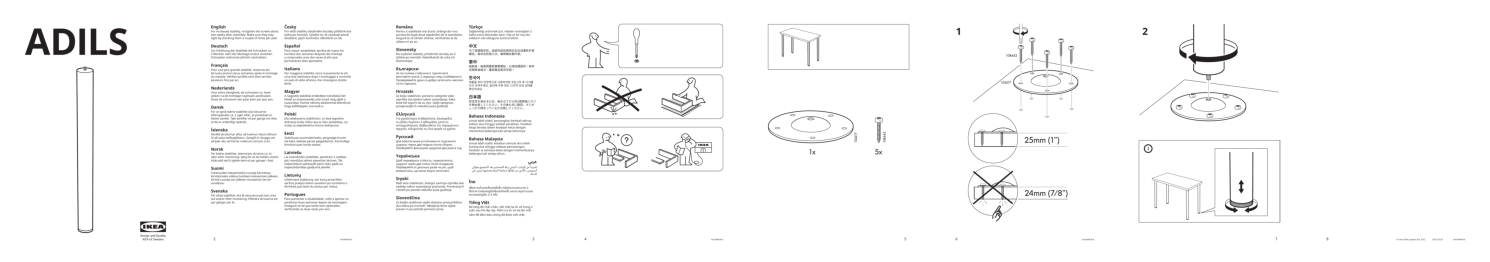

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Initialize the ColPali Multimodal Document Retrieval Model 🤖


Now that our dataset is ready, we will initialize the Document Retrieval Model, which will be responsible for extracting relevant information from the raw images and providing us with the appropriate documents based on our queries.

By utilizing this model, we can significantly enhance our conversational capabilities.

For this task, we will use **[Byaldi](https://github.com/AnswerDotAI/byaldi)**. The developers describe the library as follows: _"Byaldi is RAGatouille's mini sister project. It is a simple wrapper around the ColPali repository to make it easy to use late-interaction multi-modal models such as ColPALI with a familiar API."_

In this project, we will specifically focus on **ColPali**.

![ColPali architecture](https://github.com/illuin-tech/colpali/blob/main/assets/colpali_architecture.webp?raw=true)

Additionally, you can explore **[ViDore (The Visual Document Retrieval Benchmark)](https://huggingface.co/spaces/vidore/vidore-leaderboard)** to see the top-performing retrievers in action.


First, we will load the model from the checkpoint.


In [8]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


model-00001-of-00002.safetensors:  89%|########8 | 4.41G/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Next, we can directly index our documents using the document retrieval model by specifying the folder where the PDFs are stored. This will allow the model to process and organize the documents for efficient retrieval based on our queries.


In [9]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: data/ADILS.pdf


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: data/MALM.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of document 1 to index.
Added page 9 of document 1 to index.
Added page 10 of document 1 to index.
Added page 11 of document 1 to index.
Added page 12 of document 1 to index.
Added page 13 of document 1 to index.
Added page 14 of document 1 to index.
Added page 15 of document 1 to index.
Added page 16 of document 1 to index.
Added page 17 of document 1 to index.


{0: 'data/ADILS.pdf',
 1: 'data/MALM.pdf',
 2: 'data/BILLY.pdf',
 3: 'data/MICKE.pdf',
 4: 'data/BOAXEL.pdf'}

## 4. Retrieving Documents with the Document Retrieval Model 🤔

Having initialized the document retrieval model, we can now test its capabilities by submitting a user query and examining the relevant documents it retrieves.

The model will return the results, ranked directly by their relevance to the query.

Let’s give it a try!

In [10]:
text_query = "How many people are needed to assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=3)
results

[{'doc_id': 1, 'page_num': 1, 'score': 15.3125, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 3, 'score': 11.9375, 'metadata': {}, 'base64': None},
 {'doc_id': 2, 'page_num': 13, 'score': 11.875, 'metadata': {}, 'base64': None}]

Now, let’s examine the specific documents (images) that the model has retrieved. This will allow us to see the visual content that corresponds to our query and understand how the model selects relevant information.


In [11]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1]) # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images

grouped_images = get_grouped_images(results, all_images)

Let’s take a closer look at the retrieved documents to understand the information they contain. This examination will help us evaluate the relevance and quality of the retrieved content in relation to our query.


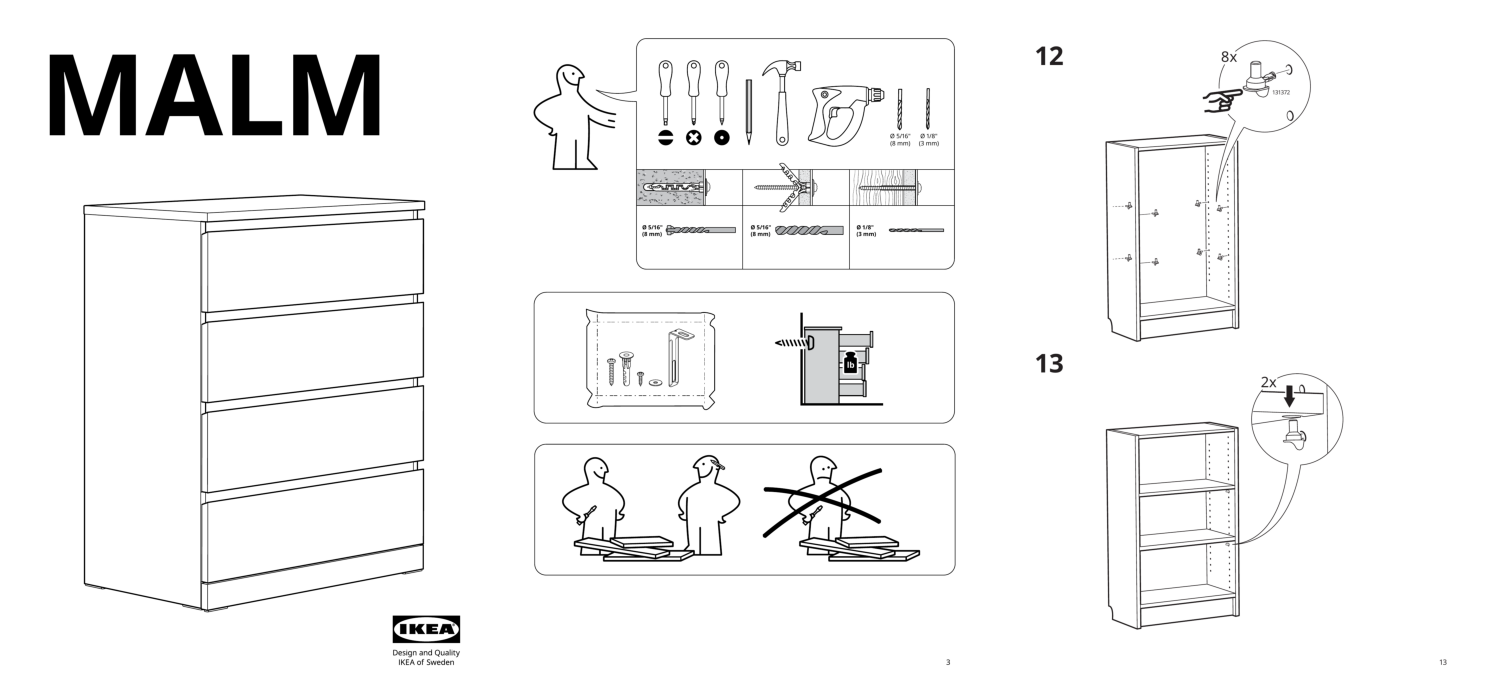

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Initialize the Visual Language Model for Question Answering 🙋

Next, we will initialize the Visual Language Model (VLM) that we will use for question answering. In this case, we’ll be utilizing **[Qwen2_VL](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl)**.

![Qwen2_VL architecture](https://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/qwen2_vl.jpg)

You can check the leaderboard for Open VLM to stay updated on the latest advancements [here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard).

First, we will load the model from the pretrained checkpoint and move it to the GPU for optimal performance.


In [ ]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

Next, we will initialize the VLM processor. In this step, we specify the minimum and maximum pixel sizes to optimize the fitting of more images into the GPU memory.

For further details on optimizing image resolution for performance, you can refer to the documentation [here](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl#image-resolution-for-performance-boost).


In [14]:
min_pixels = 224*224
max_pixels = 1024*1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## 6. Assembling the VLM Model and Testing the System 🔧

With all components loaded, we can now assemble the system for testing. First, we will create the chat structure by providing the system with the three retrieved images along with the user query. This step can be customized to fit your specific needs, allowing for greater flexibility in how you interact with the model!

In [23]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },
            {
                "type": "image",
                "image": grouped_images[2],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

Now, let's apply this chat structure.


In [24]:
text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

Next, we will process the inputs to ensure they are properly formatted and ready to be used as input for the Visual Language Model (VLM). This step is essential for enabling the model to effectively generate responses based on the provided data.

In [25]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

We are now ready to generate the answer! Let’s see how the system utilizes the processed inputs to provide a response based on the user query and the retrieved images.


In [ ]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

Once the model has generated the output, we postprocess it to generate the final answer.

In [18]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [19]:
print(output_text[0])

There are two people needed to assemble the Malm.


## 7. Assembling It All! 🧑‍🏭️

Now, let’s create a method that encompasses the entire pipeline, allowing us to easily reuse it in future applications.


In [ ]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image", "image": image} for image in grouped_images
            ] + [
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

Let’s take a look at how the complete RAG system operates!


In [ ]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="How do I assemble the Micke desk?",
    top_k=3,
    max_new_tokens=500
)
print(output_text[0])

🏆 We now have a fully operational RAG pipeline that leverages both a Document Retrieval Model and a Visual Language Model! This powerful combination enables us to generate insightful responses based on user queries and relevant documents.



## 8. Following the journey 🧑‍🎓️

...